<a href="https://colab.research.google.com/github/Axle-Bucamp/Proposition-architechture-Deep-learning/blob/main/kaggle_google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c digit-recognizer

mkdir: cannot create directory ‘/root/.kaggle’: File exists
digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip digit-recognizer.zip -d digit-recognizer

Archive:  digit-recognizer.zip
replace digit-recognizer/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np

In [ ]:
train = pd.read_csv("digit-recognizer/train.csv")
test = pd.read_csv("digit-recognizer/test.csv")
sample_submission = pd.read_csv("digit-recognizer/sample_submission.csv")

In [ ]:
y_train = train.iloc[:,0].to_numpy()
x_train = train.iloc[:,1:].to_numpy().reshape(train.shape[0] ,28 , 28, 1) / 255

x_test = test.to_numpy().reshape(test.shape[0] ,28 , 28, 1) / 255

In [ ]:
x_test.shape

(28000, 28, 28, 1)

In [ ]:
features_placeholder = tf.constant(x_train, dtype=tf.float32)
labels_placeholder = tf.constant(y_train, dtype=tf.int32)

ds_train = tf.data.Dataset.from_tensor_slices( (features_placeholder, labels_placeholder) )

In [ ]:
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(250)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

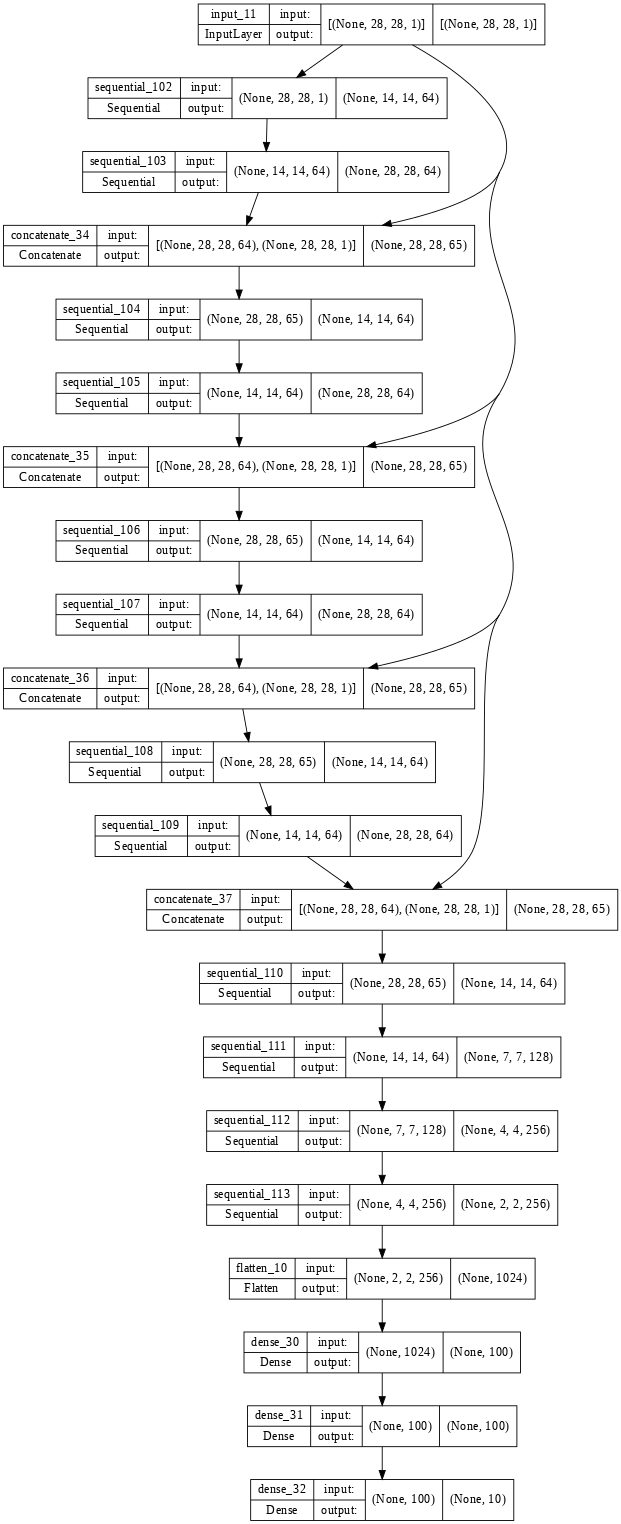

In [ ]:
inputs = tf.keras.layers.Input(shape=[28, 28, 1])

# part find interest point and compute dist between each pixel like 
down = downsample(64, 4, apply_batchnorm=True)(inputs)
up = upsample(64, 4, apply_dropout=True)(down)
model = tf.keras.layers.Concatenate()([up, inputs])
down = downsample(64, 4, apply_batchnorm=True)(model)
up = upsample(64, 4, apply_dropout=True)(down)
model = tf.keras.layers.Concatenate()([up, inputs])
down = downsample(64, 4, apply_batchnorm=False)(model)
up = upsample(64, 4, apply_dropout=True)(down)
model = tf.keras.layers.Concatenate()([up, inputs])
down = downsample(64, 4, apply_batchnorm=False)(model)
up = upsample(64, 4, apply_dropout=True)(down)
model = tf.keras.layers.Concatenate()([up, inputs])

# part analising (classique: conv + relu)
down = downsample(64, 4, apply_batchnorm=False)(model)
down = downsample(128, 4, apply_batchnorm=False)(down)
down = downsample(256, 4, apply_batchnorm=False)(down)
down = downsample(256, 4, apply_batchnorm=False)(down)
model = tf.keras.layers.Flatten()(down)
model = tf.keras.layers.Dense(100)(model)
model = tf.keras.layers.Dense(100)(model)
out = tf.keras.layers.Dense(10)(model) #,activation="softmax"

model = tf.keras.Model(inputs=inputs, outputs=out)
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile(
    optimizer=optimizer,
    loss=loss_object,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=4,
    callbacks=[callback]
)

Epoch 1/4
329/329 [==============================] - 25s 65ms/step - loss: 0.2805 - sparse_categorical_accuracy: 0.9088 - lr: 0.0010
Epoch 2/4
329/329 [==============================] - 20s 61ms/step - loss: 0.0900 - sparse_categorical_accuracy: 0.9724 - lr: 0.0010
Epoch 3/4
329/329 [==============================] - 20s 61ms/step - loss: 0.0727 - sparse_categorical_accuracy: 0.9788 - lr: 0.0010
Epoch 4/4
329/329 [==============================] - 20s 60ms/step - loss: 0.0700 - sparse_categorical_accuracy: 0.9794 - lr: 0.0010


In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD()

def scheduler(epoch, lr):
  return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile(
    optimizer=optimizer,
    loss=loss_object,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    
)

model.fit(
    ds_train,
    epochs=4,
    callbacks=[callback]
)

Epoch 1/4
329/329 [==============================] - 21s 61ms/step - loss: 0.0299 - sparse_categorical_accuracy: 0.9904 - lr: 0.0090
Epoch 2/4
329/329 [==============================] - 20s 61ms/step - loss: 0.0247 - sparse_categorical_accuracy: 0.9922 - lr: 0.0082
Epoch 3/4
329/329 [==============================] - 20s 61ms/step - loss: 0.0237 - sparse_categorical_accuracy: 0.9924 - lr: 0.0074
Epoch 4/4
329/329 [==============================] - 20s 61ms/step - loss: 0.0223 - sparse_categorical_accuracy: 0.9924 - lr: 0.0067


In [ ]:
predict = model.predict(x_test)

In [ ]:
result = list(tf.math.argmax(predict, axis=1).numpy())
list_id = list(range(1, predict.shape[0] +1, 1))

submission = pd.DataFrame(list_id, columns=["ImageId"])
submission["Label"] = result

In [ ]:
submission.to_csv("submission.csv", index=False)

In [ ]:
!kaggle competitions submit -c digit-recognizer -f submission.csv -m "Memory Down and up sampling "

100% 208k/208k [00:01<00:00, 117kB/s]
400 - Bad Request
